# Model Calibration Analysis

This notebook evaluates and improves the **calibration** of our hurricane damage classification model. A well-calibrated model produces confidence scores that accurately reflect the true probability of correctness.

## Overview
1. **Isotonic Regression Calibration** - Non-parametric calibration method
2. **Temperature Scaling** - Simple parametric calibration
3. **Generalization Testing** - Evaluate calibration on held-out test set
4. **Discard Test** - Verify uncertainty estimates quality
5. **Test-Retest Analysis** - Robustness under perturbations

In [1]:
from torch.utils.data import DataLoader
import torchvision.transforms as T
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import random
import seaborn as sns

import pytorch_lightning as pl
from pytorch_lightning import loggers as pl_loggers
from pytorch_lightning.callbacks import ModelCheckpoint

from scipy import stats

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch import optim

In [2]:
def set_seed(seed=42):
    """Set random seeds for reproducibility"""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [3]:
from src.preprocessing.data_loader import GeoEye1, compute_dataset_statistics, get_transforms, get_dataloaders
from src.models.restnet import get_resnet18, get_resnet50, count_parameters
from src.models.train import LightningClassifierModelWrapper
from src.calibration import (
    IsotonicCalibration,
    compute_ece,
    collect_logits_and_labels,
    ECELoss,
    ModelCalibrator,
    plot_reliability_diagram,
    run_discard_test,
    create_perturbed_loader,
    compute_confidence_drift,
    run_test_retest_analysis,
    plot_test_retest_results,
    print_summary_table,
    run_discard_test_all_calib

)

In [4]:
config = {
    'data_dir': os.path.join('data', 'ipeo_hurricane_for_students'),
    'image_size': 224,
    'batch_size': 32,
    'num_workers': 2,
    'max_epochs': 20,
    'lr': 1e-3,
    'weight_decay': 1e-4,
    'optimizer_type': 'adam',
    'scheduler_type': 'cosine',
    'save_dir': 'checkpoints/baseline_resnet18',
    'experiment_name': 'baseline_resnet18',
    'use_class_weights': True,
}

In [5]:
# If you already computed these, you can hardcode them:
mean = torch.tensor([0.3521, 0.3835, 0.2852]) #224*224
std = torch.tensor([0.1132, 0.0980, 0.0992]) #224*224


## 1. Data Loading

Load train/validation/test splits and compute class weights to handle class imbalance.

In [6]:

print(os.path.join('data', 'ipeo_hurricane_for_students'))
train_loader, val_loader, test_loader = get_dataloaders(
    root_dir=os.path.join('data', 'ipeo_hurricane_for_students'),
    mean=mean,
    std=std,
    image_size=config["image_size"],
    batch_size=config["batch_size"],
    num_workers=config["num_workers"]
)

print(f"Train batches: {len(train_loader)}")
print(f"Val batches:   {len(val_loader)}")
print(f"Test batches:  {len(test_loader)}")

# Analyze class distribution
train_dataset = train_loader.dataset
class_dist = train_dataset.get_class_distribution()
print(f"\nClass distribution (train): {class_dist}")

# Compute class weights for handling imbalance
if config['use_class_weights']:
    total = sum(class_dist.values())
    class_weights = [total / (len(class_dist) * count) for count in class_dist.values()]
    class_weights = torch.tensor(class_weights, dtype=torch.float32)
    print(f"Class weights: {class_weights}")
    config['class_weights'] = class_weights
else:
    config['class_weights'] = None

data\ipeo_hurricane_for_students
Loaded 19000 images for train split
Loaded 2000 images for validation split
Loaded 2000 images for test split
Train batches: 594
Val batches:   63
Test batches:  63

Class distribution (train): {'no_damage': 6000, 'damage': 13000}
Class weights: tensor([1.5833, 0.7308])


## 2. Model Loading

Load the pre-trained ResNet18 model from checkpoint.

In [7]:
from torchvision.models import resnet18
checkpoint_path = 'checkpoints/resnet18-adam-0.01-epoch=4-val_accuracy=0.98-val_f1=0.98.ckpt'

base_model = resnet18(weights=None, num_classes=2)
lightning_model = LightningClassifierModelWrapper.load_from_checkpoint(checkpoint_path,model=base_model)
model = lightning_model.model


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

C:\Users\Quentin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\pytorch_lightning\utilities\migration\utils.py:56: The loaded checkpoint was produced with Lightning v2.6.0, which is newer than your current Lightning version: v2.5.6


## 2. Isotonic Regression Calibration

**Isotonic Regression** is a non-parametric calibration method that learns a monotonic mapping from predicted probabilities to calibrated probabilities.



C:\Users\Quentin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


ECE before calibration: 0.0846

Calibrating model...
Calibration completed
ECE after calibration: 0.0000
Figure saved to figures/reliability_isotonic_val.png


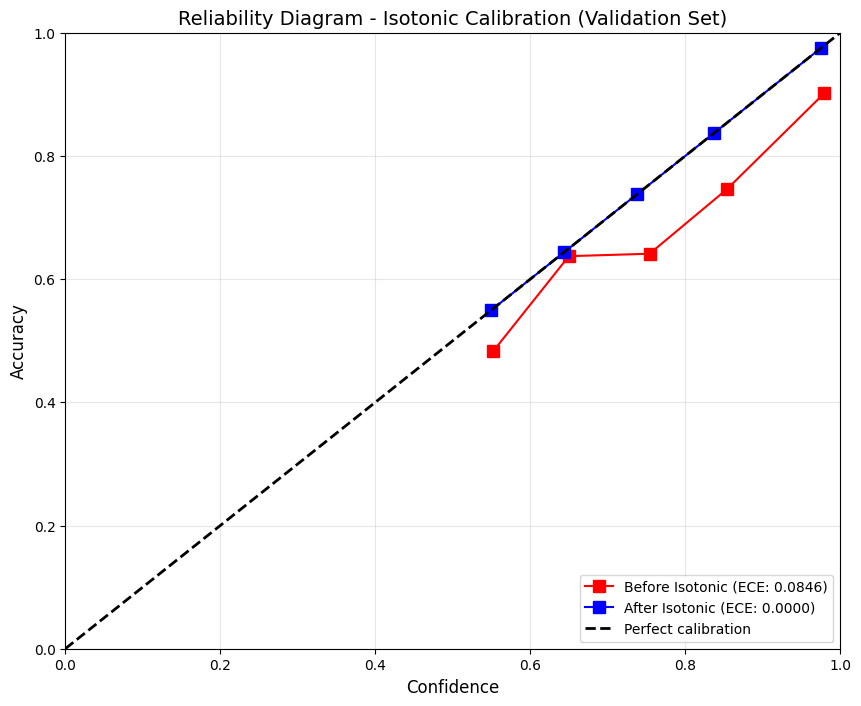

In [8]:

# Calibration procedure

lightning_model.to(device)

# 1. Collect logits on the validation set
print("Collecting logits...")
val_logits, val_labels = collect_logits_and_labels(
    lightning_model.model,
    val_loader,
    device
)

# 2. Compute ECE before calibration
nb_bins = 15
probs_before = F.softmax(val_logits, dim=1)
ece_before = compute_ece(probs_before, val_labels, n_bins=nb_bins)
print(f"ECE before calibration: {ece_before:.4f}")
# 3. Train the calibration model
print("\nCalibrating model...")
Iso_cal = IsotonicCalibration()
Iso_cal.fit(val_logits, val_labels)
print(f"Calibration completed")
# 4. Compute ECE after calibration
probs_after = Iso_cal.predict(val_logits)
ece_after = compute_ece(probs_after, val_labels)
print(f"ECE after calibration: {ece_after:.4f}")


# Before and after calibration (Validation Set)
plot_reliability_diagram(
    probs_list=[probs_before, probs_after],
    labels=val_labels,
    names=[f'Before Isotonic (ECE: {ece_before:.4f})', f'After Isotonic (ECE: {ece_after:.4f})'],
    colors=['red', 'blue'],
    title="Reliability Diagram - Isotonic Calibration (Validation Set)",
    save_path="figures/reliability_isotonic_val.png"
)



## 4. Temperature Scaling Calibration

**Temperature Scaling** is a simple post-hoc calibration method that learns a single scalar parameter $T$ to soften/sharpen the softmax output:

$$p_i = \frac{\exp(z_i / T)}{\sum_j \exp(z_j / T)}$$

- $T > 1$: Softens predictions (reduces overconfidence)
- $T < 1$: Sharpens predictions (increases confidence)

C:\Users\Quentin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Before temperature - ECE: 0.0846
Optimal temperature: 1.624
After temperature - ECE: 0.0274
Figure saved to figures/reliability_temp_scaling.png


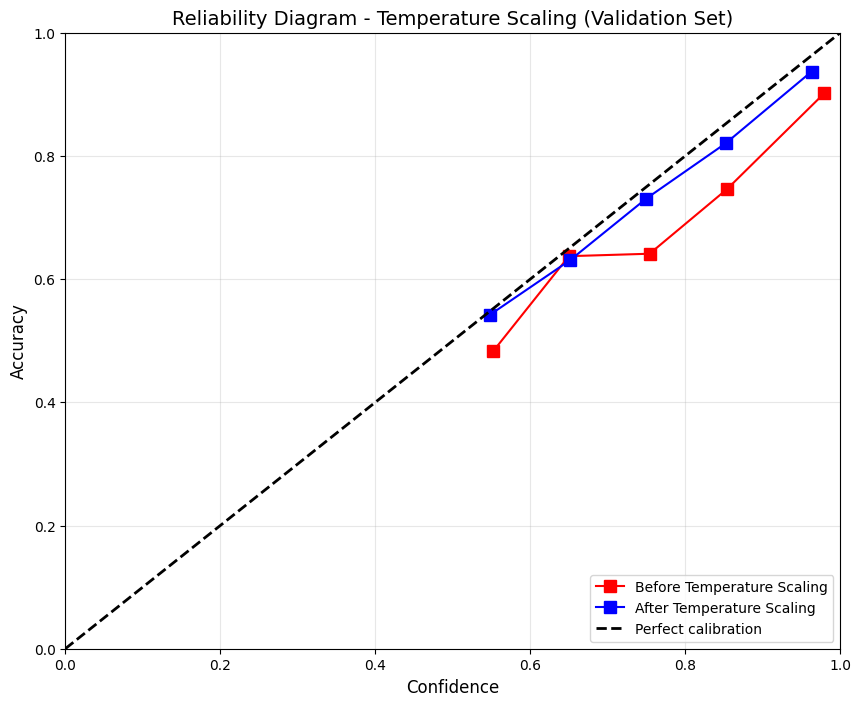

In [9]:

calibrator = ModelCalibrator(model)
calibrator.set_temperature(val_loader)

# Get probabilities for the plot
model.eval()
all_logits = []
all_labels = []
with torch.no_grad():
    for imgs, labels in val_loader:
        logits = model(imgs.to(device))
        all_logits.append(logits)
        all_labels.append(labels)

val_logits = torch.cat(all_logits)
val_labels = torch.cat(all_labels)

# Generate probabilities before and after
probs_before = F.softmax(val_logits, dim=1)
probs_after = calibrator.calibrate_probs(val_logits)

val_labels = val_labels.cpu()
probs_before = probs_before.cpu()
probs_after = probs_after.cpu()

# before and after (Validation Set)
plot_reliability_diagram(
    probs_list=[probs_before, probs_after],
    labels=val_labels,
    names=[f'Before Temperature Scaling', f'After Temperature Scaling'],
    colors=['red', 'blue'],
    title="Reliability Diagram - Temperature Scaling (Validation Set)",
    save_path="figures/reliability_temp_scaling.png"
)



## 5. Calibration Generalization Test

Evaluate how well calibration methods trained on the **validation set** generalize to the **test set**.


TESTING CALIBRATION GENERALIZATION ON TEST SET


CALIBRATION RESULTS COMPARISON

Method                    Val ECE         Test ECE        Generalization 
----------------------------------------------------------------------
Uncalibrated              0.0846          0.0812          -              
Isotonic Regression       0.0000          0.0174          ✓              
Temperature Scaling       -               0.0263          ✓              
Figure saved to figures/reliability_comparison_test.png


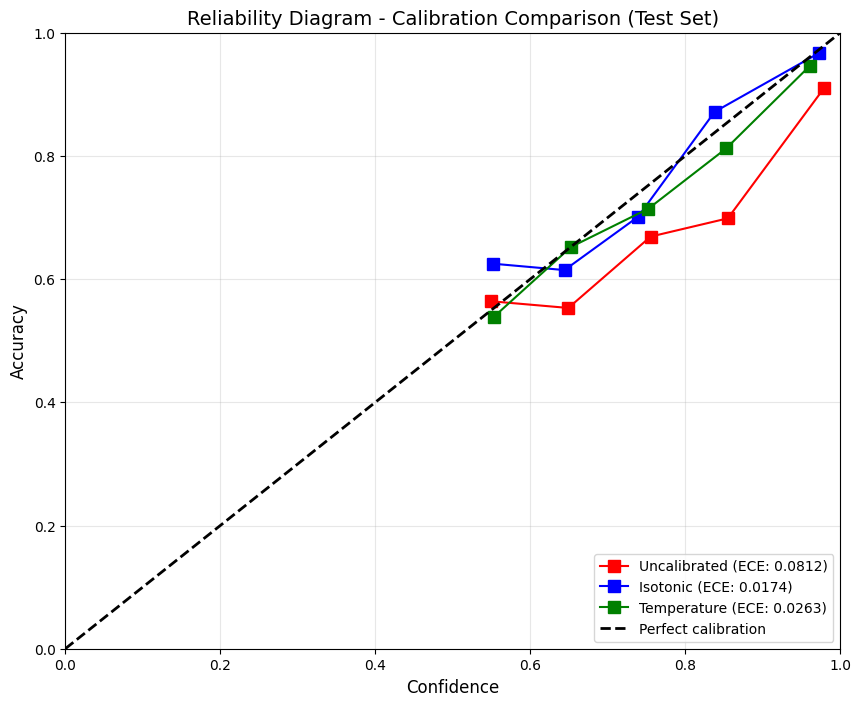


ADDITIONAL METRICS ON TEST SET

Uncalibrated:
  Accuracy: 0.8235
  Mean confidence: 0.9007
  Confidence range: [0.5008, 1.0000]

Isotonic:
  Accuracy: 0.8745
  Mean confidence: 0.8737
  Confidence range: [0.5217, 1.0000]

Temperature:
  Accuracy: 0.8235
  Mean confidence: 0.8443
  Confidence range: [0.5005, 0.9994]


In [10]:

import os
os.makedirs("figures", exist_ok=True)

print("=" * 60)
print("TESTING CALIBRATION GENERALIZATION ON TEST SET")
print("=" * 60)

# 1. Collect logits and labels on test set
print("\nCollecting test set predictions...")
test_logits, test_labels = collect_logits_and_labels(
    lightning_model.model,
    test_loader,
    device
)

# 2. Compute uncalibrated metrics on test set
probs_test_uncalibrated = F.softmax(test_logits, dim=1)
ece_test_uncalibrated = compute_ece(probs_test_uncalibrated, test_labels, n_bins=nb_bins)

# 3. Apply Isotonic Calibration (trained on val set) to test set
probs_test_isotonic = Iso_cal.predict(test_logits)
ece_test_isotonic = compute_ece(probs_test_isotonic, test_labels, n_bins=nb_bins)

# 4. Apply Temperature Scaling (trained on val set) to test set
probs_test_temperature = calibrator.calibrate_probs(test_logits.to(device)).cpu()
ece_test_temperature = compute_ece(probs_test_temperature, test_labels, n_bins=nb_bins)

# 5. Print comparison
print("\n" + "=" * 60)
print("CALIBRATION RESULTS COMPARISON")
print("=" * 60)
print(f"\n{'Method':<25} {'Val ECE':<15} {'Test ECE':<15} {'Generalization':<15}")
print("-" * 70)
print(f"{'Uncalibrated':<25} {ece_before:<15.4f} {ece_test_uncalibrated:<15.4f} {'-':<15}")
print(f"{'Isotonic Regression':<25} {ece_after:<15.4f} {ece_test_isotonic:<15.4f} {'✓' if ece_test_isotonic < ece_test_uncalibrated else '✗':<15}")
print(f"{'Temperature Scaling':<25} {'-':<15} {ece_test_temperature:<15.4f} {'✓' if ece_test_temperature < ece_test_uncalibrated else '✗':<15}")

# 6. Visualize all calibration methods on same plot (Test Set)
plot_reliability_diagram(
    probs_list=[probs_test_uncalibrated, probs_test_isotonic, probs_test_temperature],
    labels=test_labels,
    names=[
        f'Uncalibrated (ECE: {ece_test_uncalibrated:.4f})',
        f'Isotonic (ECE: {ece_test_isotonic:.4f})',
        f'Temperature (ECE: {ece_test_temperature:.4f})'
    ],
    colors=['red', 'blue', 'green'],
    title="Reliability Diagram - Calibration Comparison (Test Set)",
    save_path="figures/reliability_comparison_test.png"
)

# 7. Additional metrics: Accuracy and confidence statistics
print("\n" + "=" * 60)
print("ADDITIONAL METRICS ON TEST SET")
print("=" * 60)

for name, probs in [("Uncalibrated", probs_test_uncalibrated),
                     ("Isotonic", probs_test_isotonic),
                     ("Temperature", probs_test_temperature)]:
    confidences, predictions = torch.max(probs, 1)
    accuracy = (predictions == test_labels).float().mean().item()
    print(f"\n{name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  Mean confidence: {confidences.mean().item():.4f}")
    print(f"  Confidence range: [{confidences.min().item():.4f}, {confidences.max().item():.4f}]")

## 6. Discard Test

The **Discard Test** evaluates uncertainty quality by progressively discarding samples with highest uncertainty and measuring:
- How loss decreases as uncertain samples are removed
- Whether the model "knows what it doesn't know"

A good uncertainty estimate should show decreasing loss as we discard more uncertain predictions.

Total samples evaluated: 2000

DISCARD TEST RESULTS

Method          | MF (↑1.0)    | DI (↑)      
---------------------------------------------
Uncalibrated    | 0.8889       | 0.0342      
Isotonic        | 1.0000       | 0.0341      
Temperature     | 0.8889       | 0.0326      

Figure saved to figures/discard_test_comparison.png


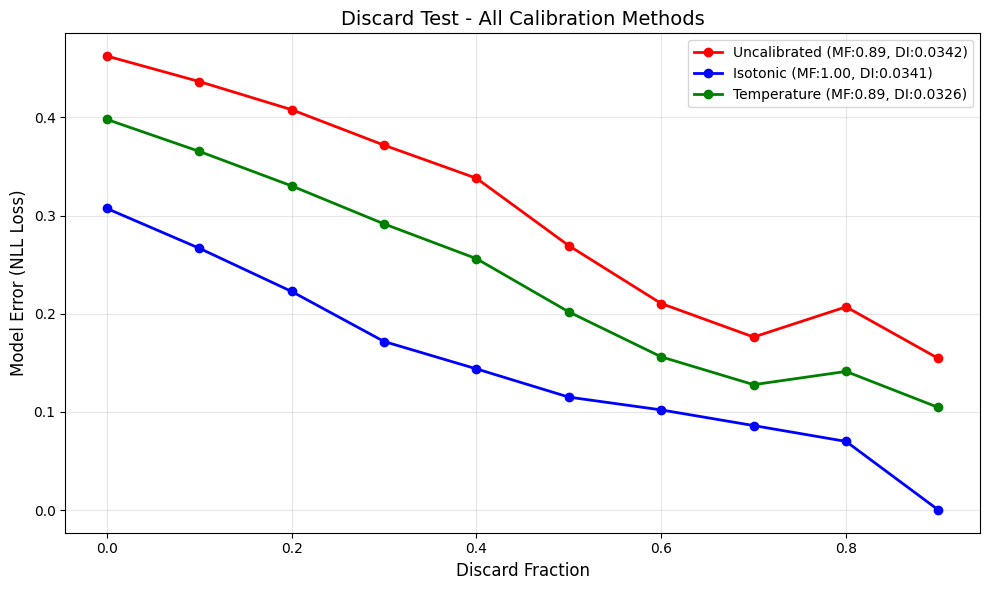

Figure saved to figures/uncertainty_density_comparison.png


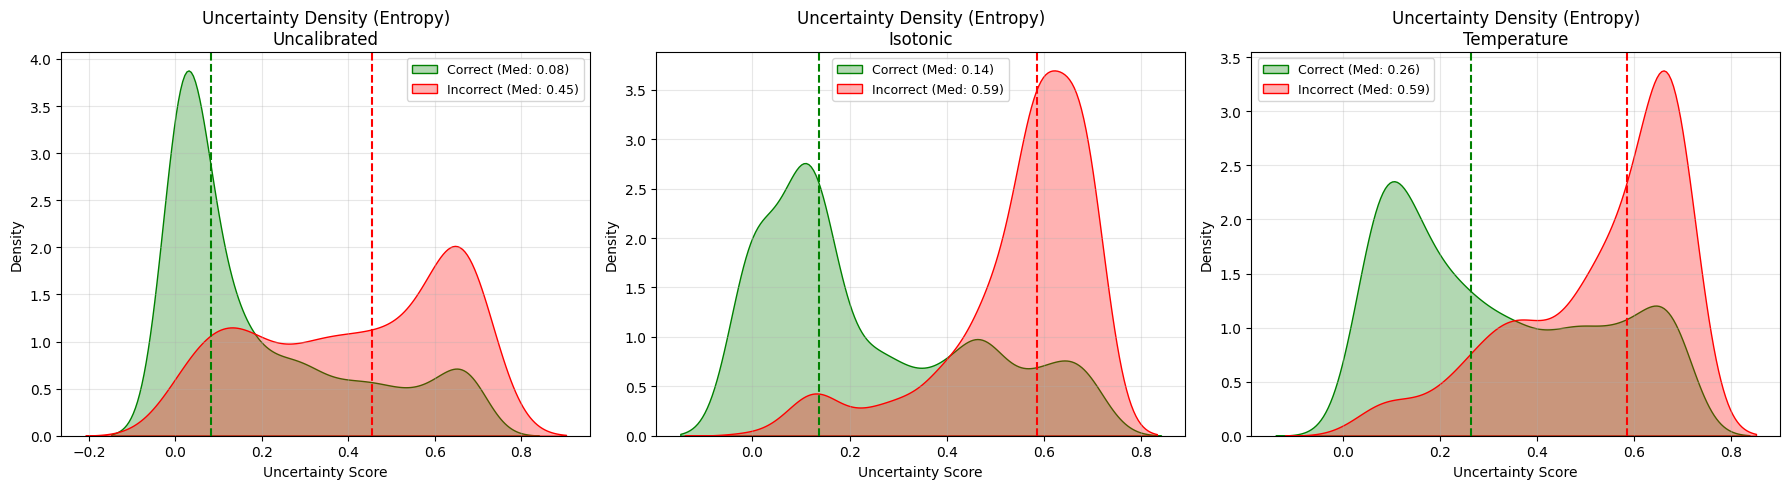

({'Uncalibrated': {'mf': np.float64(0.8888888888888888),
   'di': np.float32(0.03423746),
   'uncertainties': array([0.04619415, 0.08083577, 0.01406817, ..., 0.09950963, 0.65886766,
          0.4575664 ], shape=(2000,), dtype=float32)},
  'Isotonic': {'mf': np.float64(1.0),
   'di': np.float32(0.0341341),
   'uncertainties': array([0.45056123, 0.46922034, 0.13345242, ..., 0.48603934, 0.3196906 ,
          0.14430004], shape=(2000,), dtype=float32)},
  'Temperature': {'mf': np.float64(0.8888888888888888),
   'di': np.float32(0.03260913),
   'uncertainties': array([0.19443768, 0.2603625 , 0.1018649 , ..., 0.28938514, 0.67987233,
          0.5877646 ], shape=(2000,), dtype=float32)}},
 {'Uncalibrated': [np.float32(0.46250883),
   np.float32(0.43652853),
   np.float32(0.40783387),
   np.float32(0.37170315),
   np.float32(0.33802056),
   np.float32(0.2692846),
   np.float32(0.21037747),
   np.float32(0.17621256),
   np.float32(0.206969),
   np.float32(0.15437171)],
  'Isotonic': [np.float32

In [10]:
run_discard_test_all_calib(
    lightning_model.model, 
    test_loader, 
    device=device,
    calibrator_iso=Iso_cal,
    calibrator_temp=calibrator
)

## 7. Test-Retest Confidence Drift Analysis

Evaluate calibration **robustness** under image perturbations:
- **Blur** (light/medium)
- **Rotation** (90°, 180°, 270°)
- **Noise** (light/medium)

### Key Metrics:
- **ECE Drift**: Change in calibration error under perturbation
- **Confidence Drift**: Change in model confidence
- **Correlation**: Consistency of confidence rankings

A robust calibration method should maintain good ECE even under perturbations.

C:\Users\Quentin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



Original ECE - Uncalibrated: 0.0812, Isotonic: 0.0174, Temperature: 0.0263

Processing perturbation: blur_light...

Processing perturbation: blur_medium...

Processing perturbation: rotate_90...

Processing perturbation: rotate_180...

Processing perturbation: rotate_270...

Processing perturbation: noise_light...

Processing perturbation: noise_medium...

TEST-RETEST CONFIDENCE DRIFT SUMMARY

Perturbation    | Method       | ECE Orig   | ECE Retest | ΔECE       | Pred Cons 
------------------------------------------------------------------------------------------
blur_light      | Uncalibrated | 0.0812     | 0.0817     |    +0.0005 | 0.9945    
blur_light      | Isotonic     | 0.0174     | 0.0132     |    -0.0041 | 0.9965    
blur_light      | Temperature  | 0.0263     | 0.0292     |    +0.0029 | 0.9945    
------------------------------------------------------------------------------------------
blur_medium     | Uncalibrated | 0.0812     | 0.0594     |    -0.0217 | 0.8520    
blur_

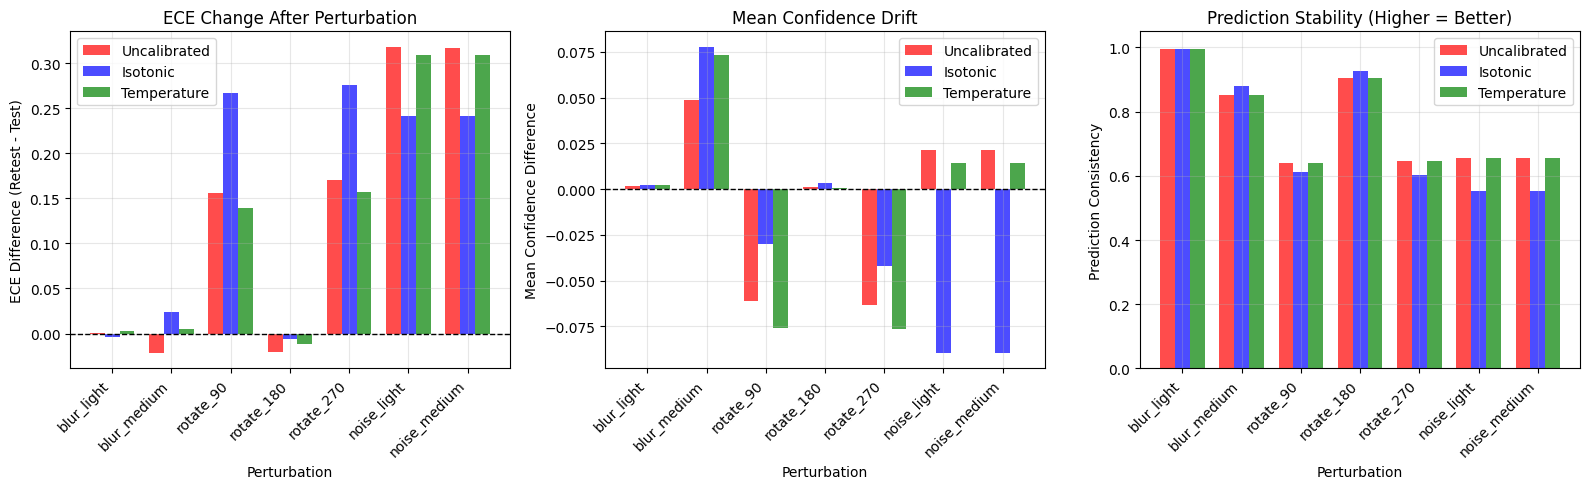

Figure saved to figures/reliability_rotate90_retest.png


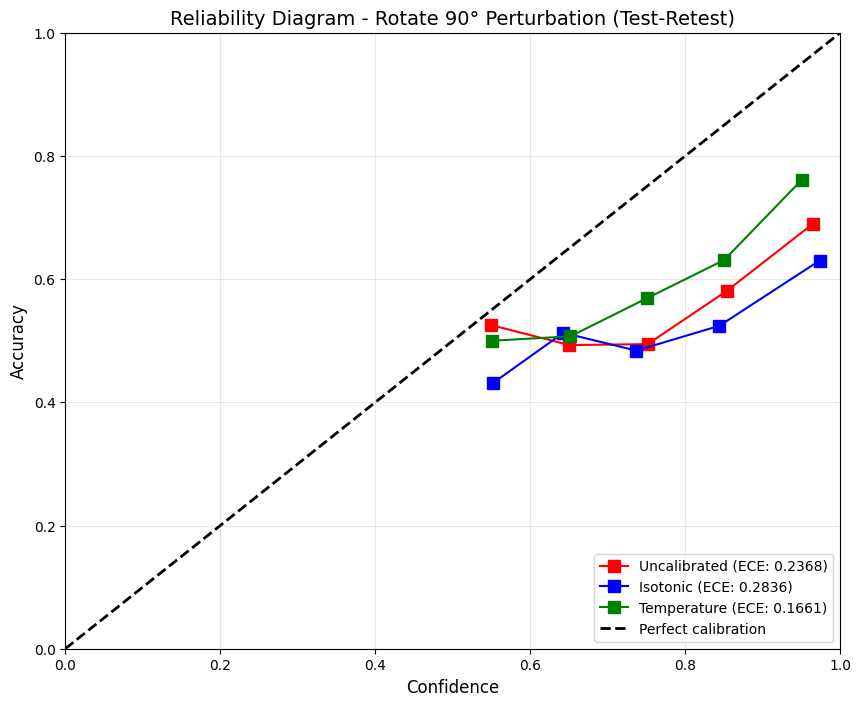

In [12]:


results, rotate90_data = run_test_retest_analysis(
    model=lightning_model.model,
    test_loader=test_loader,
    calibrator_iso=Iso_cal,
    calibrator_temp=calibrator,
    device=device
)

# Print summary table
print_summary_table(results)

# Visualize results
plot_test_retest_results(results)

# Plot Reliability Diagram for rotate_90 perturbation
if rotate90_data is not None:
    plot_reliability_diagram(
        probs_list=[
            rotate90_data['probs_uncal'],
            rotate90_data['probs_iso'],
            rotate90_data['probs_temp']
        ],
        labels=rotate90_data['labels'],
        names=[
            f"Uncalibrated (ECE: {rotate90_data['ece_uncal']:.4f})",
            f"Isotonic (ECE: {rotate90_data['ece_iso']:.4f})",
            f"Temperature (ECE: {rotate90_data['ece_temp']:.4f})"
        ],
        colors=['red', 'blue', 'green'],
        title="Reliability Diagram - Rotate 90° Perturbation (Test-Retest)",
        save_path="figures/reliability_rotate90_retest.png"
    )